# Eigenfaces

The dataset consists of images of 38 people. For each person, there are 9 poses and 64 lighting conditions, for a total of 21888 images. Each image is 192 pixels tall and 168 pixels wide; when flattened, it is a vector with 32,256 elements.

In [14]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 16})

Download data file if it is not present.

In [15]:
if os.path.isfile('../DATA/allFaces.mat') == False:
    !mkdir -p ../DATA
    !wget -P ../DATA -c https://bitbucket.org/cpraveen/nla/downloads/allFaces.mat

Load the images

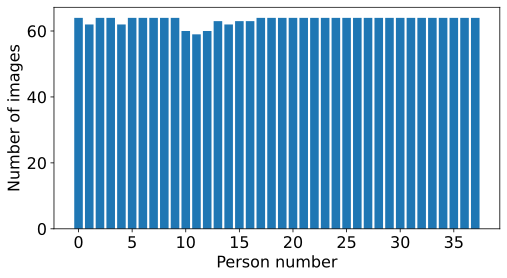

In [16]:
mat_contents = scipy.io.loadmat('../DATA/allFaces.mat')
faces = mat_contents['faces']
m = int(mat_contents['m'][0][0]) # pixels per image
n = int(mat_contents['n'][0][0]) # pixels per image
nfaces = np.ndarray.flatten(mat_contents['nfaces'])

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(nfaces)),nfaces)
plt.xlabel('Person number')
plt.ylabel('Number of images')
plt.show()

 and plot the first 36 of them.

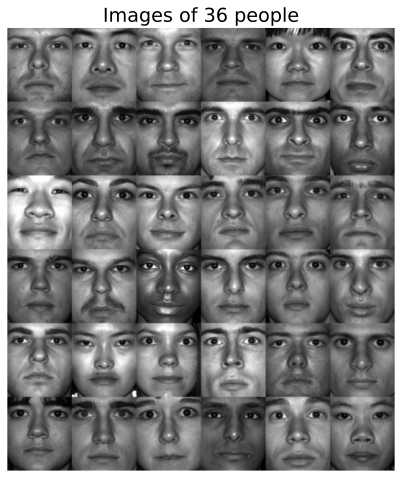

In [17]:
allPersons = np.zeros((n*6,m*6))
count = 0

for j in range(6):
    for k in range(6):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(faces[:,np.sum(nfaces[:count])],(m,n)).T
        count += 1
        
img = plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.title('Images of 36 people')
plt.show()

Let us use the first 36 people as the data. We compute the average image and subtract it from all images. The images are then stacked as columns of a matrix $X$ of size $m \times n = 32256 \times 2282$.

$$
\textrm{$j$'th image} = x_j \in R^m, \qquad\qquad \textrm{Average image} = \bar x = \frac{1}{n} \sum_{j=1}^n x_j
$$

$$
X = \begin{bmatrix}
| & | & & | \\
x_1 - \bar x & x_2 - \bar x & \ldots & x_n - \bar x \\
| & | & & | 
\end{bmatrix} \in R^{m \times n}
$$

The reduced SVD is

$$
X = \hat U \hat\Sigma V^\top, \qquad 
\hat U = \begin{bmatrix} 
| & | & & | \\
u_1 & u_2 & \ldots & u_n \\ 
| & | & & | 
\end{bmatrix}, \qquad
\hat \Sigma = \textrm{diag}[\sigma_1, \ldots, \sigma_n], \qquad
V = \begin{bmatrix} 
| & | & & | \\
v_1 & v_2 & \ldots & v_n \\ 
| & | & & | 
\end{bmatrix}
$$

Each $u_j \in R^m$ and these form an orthonormal basis for images.

In [18]:
# We use the first 36 people for training data
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1) # size n*m by 1

# Compute eigenfaces on mean-subtracted training data
X = trainingFaces - np.tile(avgFace,(trainingFaces.shape[1],1)).T
print('Size of X = ', X.shape)
U, S, VT = np.linalg.svd(X,full_matrices=0)

Size of X =  (32256, 2282)


Plot the average face and first few eigenfaces.

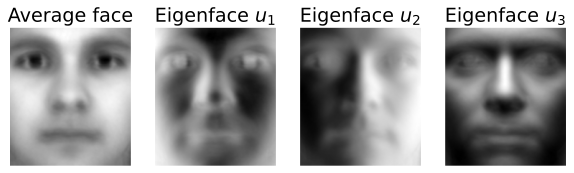

In [19]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(141)
img_avg = ax1.imshow(np.reshape(avgFace,(m,n)).T)
img_avg.set_cmap('gray')
plt.title('Average face')
plt.axis('off')

ax2 = fig1.add_subplot(142)
img_u1 = ax2.imshow(np.reshape(U[:,0],(m,n)).T)
img_u1.set_cmap('gray')
plt.title('Eigenface $u_1$')
plt.axis('off')

ax3 = fig1.add_subplot(143)
img_u2 = ax3.imshow(np.reshape(U[:,1],(m,n)).T)
img_u2.set_cmap('gray')
plt.title('Eigenface $u_2$')
plt.axis('off')

ax4 = fig1.add_subplot(144)
img_u3 = ax4.imshow(np.reshape(U[:,2],(m,n)).T)
img_u3.set_cmap('gray')
plt.title('Eigenface $u_3$')
plt.axis('off')

plt.show()

The singular values decrease very rapidly.

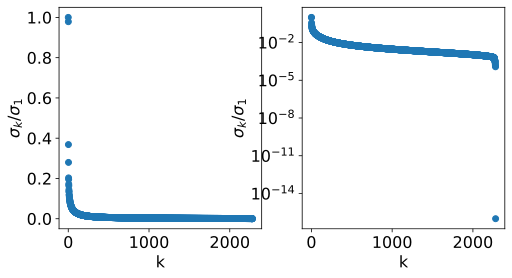

In [20]:
# Plot singular values: linear scale
fig2 = plt.figure(figsize=(8,4))
ax = fig2.add_subplot(121)
ax.plot(S/S[0],'o')
ax.set_xlabel('k')
ax.set_ylabel('$\\sigma_k / \\sigma_1$')

# Plot singular values: log scale
ax = fig2.add_subplot(122)
ax.semilogy(S/S[0],'o')
ax.set_xlabel('k')
ax.set_ylabel('$\\sigma_k / \\sigma_1$')

plt.show()

The principal components of the $j$'th image are

$$
\alpha_j = U^\top (x_j - \bar x) \in R^n
$$

Using the first $r$ principal components, the reconstructed image is

$$
\tilde x_j = \bar x + \sum_{k=1}^r (\alpha_j)_k u_k = \bar x + U_r U^\top_r (x_j - \bar x)
$$

where

$$
U_r = \begin{bmatrix}
| & | & & | \\
u_1 & u_2 & \ldots & u_r \\
| & | & & |
\end{bmatrix} \in R^{m \times r}
$$

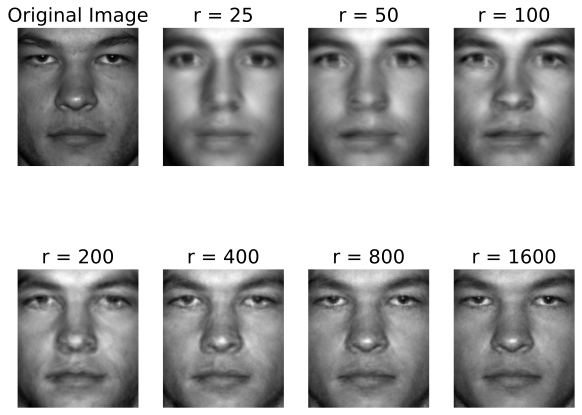

In [21]:
## Now show eigenface reconstruction of image that was omitted from test set
fig = plt.figure(figsize=(10,8))

c = 1; ax = fig.add_subplot(2,4,c)
testFace = faces[:,np.sum(nfaces[:36])] # First face of person 37
img = ax.imshow(np.reshape(testFace,(m,n)).T)
img.set_cmap('gray')
plt.title('Original Image')
plt.axis('off')

testFaceMS = testFace - avgFace
r_list = [25, 50, 100, 200, 400, 800, 1600]

for r in r_list:
    c = c + 1; ax = fig.add_subplot(2,4,c)
    reconFace = avgFace + U[:,:r]  @ (U[:,:r].T @ testFaceMS)
    img = ax.imshow(np.reshape(reconFace,(m,n)).T)
    img.set_cmap('gray')
    plt.title('r = ' + str(r))
    plt.axis('off')

plt.show()

The first 1600 principal components give a good approximation of the true image. This can provide a method for image compression, we only need to store a few principal components for each image. The average image and the basis must also be stored, but these are common to all images.

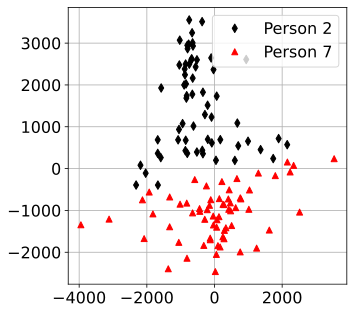

In [22]:
## Project person 2 and 7 onto PC5 and PC6

P1num = 2 # Person number 2
P2num = 7 # Person number 7

P1 = faces[:,np.sum(nfaces[:(P1num-1)]):np.sum(nfaces[:P1num])]
P2 = faces[:,np.sum(nfaces[:(P2num-1)]):np.sum(nfaces[:P2num])]

P1 = P1 - np.tile(avgFace,(P1.shape[1],1)).T
P2 = P2 - np.tile(avgFace,(P2.shape[1],1)).T

PCAmodes = [5, 6] # Project onto PCA modes 5 and 6
PCACoordsP1 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P1
PCACoordsP2 = U[:,PCAmodes-np.ones_like(PCAmodes)].T @ P2

plt.figure(figsize=(5,5))
plt.plot(PCACoordsP1[0,:],PCACoordsP1[1,:],'d',color='k',label='Person 2')
plt.plot(PCACoordsP2[0,:],PCACoordsP2[1,:],'^',color='r',label='Person 7')
plt.grid(True)
plt.legend()
plt.show()

The two persons seem to be well separated in PC space. This suggests that we can use the principal components for image recognition.